## Figure 2. Comparing RD, FD and BP



Imports

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

Populating the interactive namespace from numpy and matplotlib


## A. Dependence on $p$ and $c$

In [4]:
nsims = 50
cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
pvals = np.linspace(0.02, 1, 10)

tau_s = 0.020
dt = 0.001
t = 50

alpha1 = -30
alpha2 = 20
x = 2

DeltaT = 50

params = ParamsLIF()
params_orig = ParamsLIF()
lif = LIF(params, t = t)

t_filter = np.linspace(0, 0.150, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#c (correlation between noise inputs)
beta_rd_c = np.zeros((len(cvals), nsims, len(pvals), params.n))
beta_fd_c = np.zeros((len(cvals), nsims, params.n))
beta_bp_c = np.zeros((len(cvals), nsims, params.n))

beta_rd_c_linear = np.zeros((len(cvals), nsims, len(pvals), params.n))
beta_fd_c_linear = np.zeros((len(cvals), nsims, params.n))

m_beta_bp_c = np.zeros(params.n)
m_beta_rd_c = np.zeros((len(cvals), params.n))
se_beta_fd_c = np.zeros((len(cvals), params.n))
m_beta_rd_c = np.zeros((len(cvals), params.n))
se_beta_fd_c = np.zeros((len(cvals), params.n))

m_beta_rd_c_linear = np.zeros((len(cvals), params.n))
se_beta_fd_c_linear = np.zeros((len(cvals), params.n))
m_beta_rd_c_linear = np.zeros((len(cvals), params.n))
se_beta_fd_c_linear = np.zeros((len(cvals), params.n))

In [3]:
beta_sp_c = np.zeros((len(cvals), params.n))
cost = lambda s1, s2: (alpha1*s1 + alpha2*s2 - x**2)**2

In [4]:
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in range(nsims):
        (v, h, _, _) = lif.simulate()
        s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
        s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]
        cost_s = cost(s1, s2)
        for k,p in enumerate(pvals):
            #print("p = %f"%p)
            beta_rd_c[i,j,k,:] = causaleffect_maxv(v, cost_s, DeltaT, p, params)
            beta_rd_c_linear[i,j,k,:] = causaleffect_maxv_linear(v, cost_s, DeltaT, p, params)
        beta_fd_c[i,j,:] = causaleffect_maxv(v, cost_s, DeltaT, 1, params)
        beta_fd_c_linear[i,j,:] = causaleffect_maxv_linear(v, cost_s, DeltaT, 1, params)
        #Compute the SP cost
        beta_sp_c[i,:] = causaleffect_maxv_sp(v, h, cost, DeltaT, params, exp_filter)        

Running 50 simulations with c=0.01
Running 50 simulations with c=0.25
Running 50 simulations with c=0.5
Running 50 simulations with c=0.75
Running 50 simulations with c=0.99


In [5]:
m_beta_rd_c = np.mean(beta_rd_c, 1)
se_beta_rd_c = np.std(beta_rd_c, 1)
m_beta_fd_c = np.mean(beta_fd_c, 1)
se_beta_fd_c = np.std(beta_fd_c, 1)

m_beta_rd_c_linear = np.mean(beta_rd_c_linear, 1)
se_beta_rd_c_linear = np.std(beta_rd_c_linear, 1)
m_beta_fd_c_linear = np.mean(beta_fd_c_linear, 1)
se_beta_fd_c_linear = np.std(beta_fd_c_linear, 1)

Use seaborn for plotting

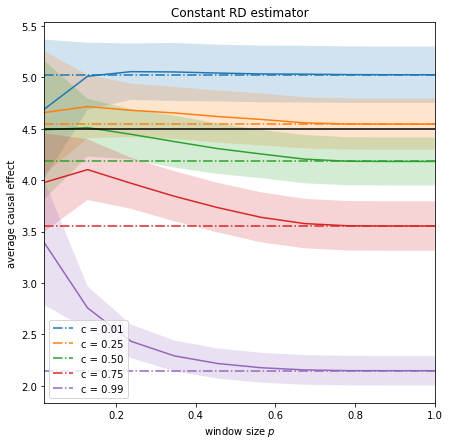

In [8]:
u = 0
fig,ax = plt.subplots(1,1,figsize=(7,7))
for i in range(len(cvals)):
    sns.tsplot(data = beta_rd_c[i,:,:,u], ax = ax, ci='sd', time=pvals, color='C%d'%i)
    ax.plot(pvals, m_beta_rd_c[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
ax.set_xlabel('window size $p$');
ax.set_ylabel('average causal effect');
ax.set_title('Constant RD estimator');
ax.plot(pvals, beta_sp_c[0,u]*ones(pvals.shape), color=(0,0,0));
#ax.set_ylim([0, 1])
ax.legend(["c = %.2f"%i for i in cvals]);
#plt.savefig('./fig_2a.pdf')

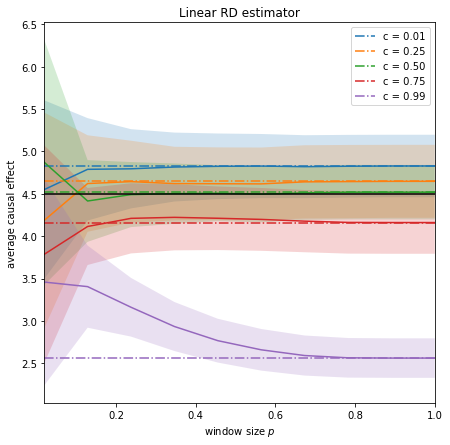

In [9]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
for i in range(len(cvals)):
    sns.tsplot(data=beta_rd_c_linear[i,:,:,u], ax = ax, ci='sd', time=pvals, color='C%d'%i)
    ax.plot(pvals, m_beta_rd_c_linear[i,-1,u]*ones(pvals.shape), '-.', color='C%d'%i)
ax.set_xlabel('window size $p$');
ax.set_ylabel('average causal effect');
ax.set_title('Linear RD estimator');
ax.plot(pvals, beta_sp_c[0,u]*ones(pvals.shape), color=(0,0,0));
#ax.set_ylim([0, 1])
ax.legend(["c = %.2f"%i for i in cvals]);
plt.savefig('./fig_2a_linear.pdf')

## B. Histogram over range of weights

In [12]:
nsims = 1
N = 19
c = 0.5
p = 0.03
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

In [317]:
beta_rd_w = np.zeros((N, N, nsims, params.n))
beta_fd_w = np.zeros((N, N, nsims, params.n))
beta_sp_w = np.zeros((N, N, nsims, params.n))
m_beta_rd_w = np.zeros((N, N, params.n))
m_beta_fd_w = np.zeros((N, N, params.n))
m_beta_bp_w = np.zeros((N, N, params.n))

mu_s1 = np.zeros((N, N))
mu_s2 = np.zeros((N, N))
sigma_s1s1 = np.zeros((N, N))
sigma_s1s2 = np.zeros((N, N))
sigma_s2s2 = np.zeros((N, N))

mu_s1_tmp = np.zeros((nsims))
mu_s2_tmp = np.zeros((nsims))
sigma_s1s1_tmp = np.zeros((nsims))
sigma_s1s2_tmp = np.zeros((nsims))
sigma_s2s2_tmp = np.zeros((nsims))


In [319]:
for i,w1 in enumerate(wvals):
    print("Estimating betas for W0 = %d"%w1)
    for j,w2 in enumerate(wvals):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            cost_s = (alpha1*s1 + alpha2*s2 - x**2)**2
            beta_rd_w[i,j,k,:] = causaleffect_maxv(vs[i,j,k,:,:], cost_s, DeltaT, p, params)
            beta_fd_w[i,j,k,:] = causaleffect_maxv(vs[i,j,k,:,:], cost_s, DeltaT, 1, params)
            beta_sp_w[i,j,k,:] = causaleffect_maxv_sp(vs[i,j,k,:,:], hs[i,j,k,:,:], cost, DeltaT, params, exp_filter) 

Estimating betas for W0 = 2


NameError: name 'cost' is not defined

In [14]:
m_beta_rd_w = np.mean(beta_rd_w, 2)
se_beta_rd_w = np.std(beta_rd_w, 2)
m_beta_fd_w = np.mean(beta_fd_w, 2)
se_beta_fd_w = np.std(beta_fd_w, 2)
m_beta_sp_w = np.mean(beta_sp_w, 2)
se_beta_sp_w = np.std(beta_sp_w, 2)

In [15]:
d_fdbp = np.sqrt((m_beta_fd_w[:,:,0]-m_beta_sp_w[:,:,0])**2 + (m_beta_fd_w[:,:,1]-m_beta_sp_w[:,:,1])**2).reshape((-1,1))
d_rdbp = np.sqrt((m_beta_rd_w[:,:,0]-m_beta_sp_w[:,:,0])**2 + (m_beta_rd_w[:,:,1]-m_beta_sp_w[:,:,1])**2).reshape((-1,1))

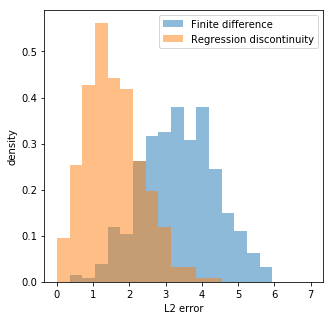

In [20]:
plt.rc('text', usetex=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5));
ax1.hist(d_fdbp, 20, normed=1, range=(0, 7), alpha=0.5);
ax1.hist(d_rdbp, 20, normed=1, range=(0, 7), alpha=0.5);
ax1.set_xlabel('L2 error')
ax1.set_ylabel('density')
ax1.legend(['Finite difference', 'Regression discontinuity']);
plt.savefig('./fig_2b.pdf')

## C. Heatmaps of cost landscape and gradient estimates

The 'banana' cost function with RD (compared with numerical gradient), and FD (compard with numerical cost gradient).

Possibly also BP (compared with numerical gradient)

In [226]:
c = 0.99

#nsims = 500
#N = 20
#fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)

nsims = 1
N = 19
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_deltaT_simulations.npz'%(N, nsims, c)

sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

In [227]:
#Reshape so we have more than one sim
#nsims = 10
#hs = np.reshape(hs, (N, N, nsims, 2, -1))
#vs = np.reshape(vs, (N, N, nsims, 2, -1))

In [320]:
DeltaT = 20

tau_s = 0.2

p = 0.2
wmax = 20
wmin = 2

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

cost2 = np.zeros((N,N))
cost2_tmp = np.zeros((nsims,hs.shape[4]))

beta_fd_w2 = np.zeros((nsims, params.n))
beta_rd_w2 = np.zeros((nsims, params.n))
beta_sp_w2 = np.zeros((nsims, params.n))

m_beta_fd_w2 = np.zeros((N, N, params.n))
m_beta_rd_w2 = np.zeros((N, N, params.n))
m_beta_sp_w2 = np.zeros((N, N, params.n))

mu_s1 = np.zeros((N, N))
mu_s2 = np.zeros((N, N))
sigma_s1s1 = np.zeros((N, N))
sigma_s1s2 = np.zeros((N, N))
sigma_s2s2 = np.zeros((N, N))

mu_s1_tmp = np.zeros((nsims))
mu_s2_tmp = np.zeros((nsims))
sigma_s1s1_tmp = np.zeros((nsims))
sigma_s1s2_tmp = np.zeros((nsims))
sigma_s2s2_tmp = np.zeros((nsims))

B1 = 1
B2 = 2
x = .01
y = 0.1
z = 0
cost2_fun = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

#alpha1 = -30
#alpha2 = 20
#x = 2
#cost2_fun = lambda s1, s2: (alpha1*s1 + alpha2*s2 - x**2)**2

#Tmax = 500000
#cost2_tmp = np.zeros((nsims,Tmax))

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            #s1 = np.convolve(hs[i,j,k,0,0:Tmax], exp_filter)[0:Tmax]
            #s2 = np.convolve(hs[i,j,k,1,0:Tmax], exp_filter)[0:Tmax]
            cost2_tmp[k,:] = cost2_fun(s1, s2)
            beta_fd_w2[k,:] = causaleffect_maxv(vs[i,j,k,:,:], cost2_tmp[k,:], DeltaT, 1, params)
            #beta_rd_w2[k,:] = causaleffect_maxv(vs[i,j,k,:,:], cost2_tmp[k,:], DeltaT, p, params)
            beta_rd_w2[k,:] = causaleffect_maxv_linear(vs[i,j,k,:,:], cost2_tmp[k,:], DeltaT, p, params)
            beta_sp_w2[k,:] = causaleffect_maxv_sp(vs[i,j,k,:,:], hs[i,j,k,:,:], cost2_fun, DeltaT, params, exp_filter)

            mu_s1_tmp[k] = np.mean(s1)
            mu_s2_tmp[k] = np.mean(s2)
            cov = np.cov(s1, s2)
            sigma_s1s1_tmp[k] = cov[0,0]
            sigma_s1s2_tmp[k] = cov[0,1]
            sigma_s2s2_tmp[k] = cov[1,1]

        cost2[i,j] = np.mean(cost2_tmp)
        m_beta_rd_w2[i,j,:] = np.mean(beta_rd_w2, 0)
        m_beta_fd_w2[i,j,:] = np.mean(beta_fd_w2, 0)
        m_beta_sp_w2[i,j,:] = np.mean(beta_sp_w2, 0)

        mu_s1[i,j] = np.mean(mu_s1_tmp)
        mu_s2[i,j] = np.mean(mu_s2_tmp)
        sigma_s1s1[i,j] = np.mean(sigma_s1s1_tmp)
        sigma_s1s2[i,j] = np.mean(sigma_s1s2_tmp)
        sigma_s2s2[i,j] = np.mean(sigma_s2s2_tmp)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18


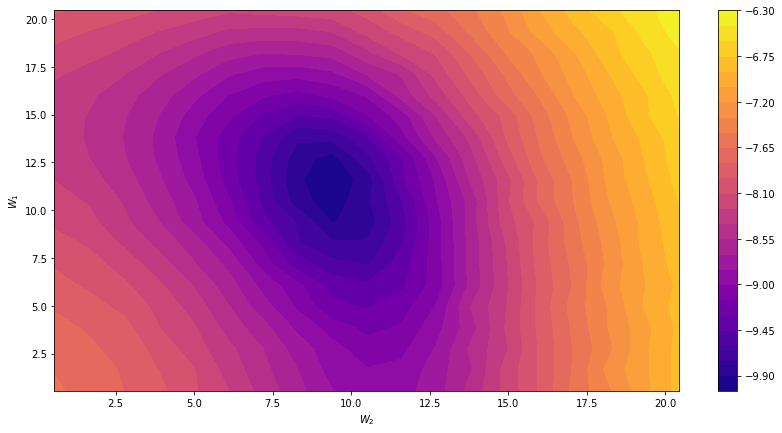

In [308]:
fig, (ax1) = plt.subplots(1,figsize=(14,7))
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
fig.colorbar(a);
ax1.set_xlabel('$W_2$')
ax1.set_ylabel('$W_1$')

In [239]:
mu1_w1 = array([[ 0.00038599,  0.00040598,  0.00039597,  0.00042193,  0.00036397,
         0.000488  ,  0.00042984,  0.00042002,  0.00043874,  0.00041903,
         0.00042666,  0.000456  ,  0.00036799,  0.00040069,  0.000388  ,
         0.00039414,  0.00048585,  0.00039574,  0.00041769],
       [ 0.00050005,  0.0005207 ,  0.00049005,  0.00051019,  0.00050673,
         0.00056246,  0.000505  ,  0.00049696,  0.0004818 ,  0.00053866,
         0.000508  ,  0.00051081,  0.00055979,  0.00047087,  0.00052298,
         0.00047997,  0.00049696,  0.000495  ,  0.00050546],
       [ 0.00068158,  0.00065558,  0.00062987,  0.00075025,  0.00069399,
         0.00068363,  0.00066428,  0.00069108,  0.00068236,  0.00070605,
         0.00069582,  0.0006529 ,  0.00068986,  0.00071986,  0.00070854,
         0.00068881,  0.00065902,  0.00069495,  0.00063837],
       [ 0.00084199,  0.00084161,  0.00080746,  0.00082982,  0.00083486,
         0.00080771,  0.00088978,  0.00091595,  0.00088368,  0.00079918,
         0.00083571,  0.00084361,  0.00087883,  0.00087306,  0.00084834,
         0.00089165,  0.00087076,  0.00086166,  0.00082482],
       [ 0.00101953,  0.00103083,  0.00098083,  0.00089556,  0.00098754,
         0.00091789,  0.00095904,  0.00089429,  0.00093192,  0.00089792,
         0.00087846,  0.00092458,  0.00098362,  0.00096864,  0.00098059,
         0.00095205,  0.00099718,  0.00093202,  0.00093931],
       [ 0.00111135,  0.00106748,  0.00114005,  0.00109796,  0.00106708,
         0.00103859,  0.00106712,  0.00108993,  0.00100918,  0.00112311,
         0.00107799,  0.00108532,  0.00099543,  0.00110689,  0.00109881,
         0.00106763,  0.00109919,  0.00109064,  0.00102853],
       [ 0.00118278,  0.00117647,  0.0012955 ,  0.0012525 ,  0.00118136,
         0.00123439,  0.00120861,  0.00137386,  0.00120989,  0.00128787,
         0.00133611,  0.00128664,  0.00123063,  0.0011746 ,  0.00125785,
         0.00121213,  0.00115176,  0.0012656 ,  0.00128238],
       [ 0.00133791,  0.00133278,  0.00134302,  0.00137175,  0.00135494,
         0.00135622,  0.00132922,  0.0011377 ,  0.00147214,  0.0012396 ,
         0.00132006,  0.00130101,  0.00131254,  0.00133562,  0.00122744,
         0.00130411,  0.00126878,  0.00128063,  0.00138525],
       [ 0.00142574,  0.00131628,  0.00127544,  0.00139871,  0.00136446,
         0.00135486,  0.00142257,  0.00130103,  0.0013225 ,  0.00140089,
         0.00136071,  0.00143726,  0.00130831,  0.0014774 ,  0.00138227,
         0.00143248,  0.00142286,  0.00136075,  0.00138667],
       [ 0.0014238 ,  0.00145456,  0.00138087,  0.00141743,  0.00140936,
         0.00142052,  0.00136963,  0.00153202,  0.00137771,  0.00143962,
         0.0015589 ,  0.00147152,  0.00146363,  0.00141913,  0.00146648,
         0.00139234,  0.00156631,  0.00151228,  0.00145267],
       [ 0.00148697,  0.00160463,  0.00166421,  0.00145639,  0.00160499,
         0.00151973,  0.00152333,  0.00156144,  0.00168855,  0.00150168,
         0.0014435 ,  0.00141151,  0.00149003,  0.00147737,  0.00154546,
         0.00155103,  0.00158634,  0.00158611,  0.00157017],
       [ 0.00151277,  0.00164954,  0.0017444 ,  0.00161395,  0.0017039 ,
         0.00162787,  0.00157896,  0.00173744,  0.00160001,  0.00169206,
         0.00155788,  0.00161477,  0.00153097,  0.00165782,  0.00173219,
         0.0017318 ,  0.00158837,  0.00155546,  0.0016032 ],
       [ 0.00171402,  0.00169213,  0.00165084,  0.00175836,  0.00169167,
         0.0018382 ,  0.00175515,  0.00172877,  0.00165181,  0.00183087,
         0.00169965,  0.00177343,  0.00183747,  0.00156226,  0.00162345,
         0.00164613,  0.0016256 ,  0.0016944 ,  0.00168483],
       [ 0.00182761,  0.00172024,  0.00174301,  0.0018124 ,  0.00179938,
         0.00177177,  0.00193176,  0.00169098,  0.00190236,  0.00165908,
         0.00175208,  0.00173567,  0.00189416,  0.0017855 ,  0.00166039,
         0.0017661 ,  0.00173364,  0.00178818,  0.00172257],
       [ 0.0017741 ,  0.00176305,  0.0017226 ,  0.00182671,  0.00190443,
         0.00165484,  0.00176612,  0.00177527,  0.0017661 ,  0.00171671,
         0.00172309,  0.00177123,  0.0018007 ,  0.00188633,  0.00176034,
         0.00177719,  0.00183588,  0.00175412,  0.00181269],
       [ 0.00193957,  0.00195359,  0.0019136 ,  0.00185922,  0.00162685,
         0.0016888 ,  0.00170052,  0.00183721,  0.0016231 ,  0.00202352,
         0.00191789,  0.00177132,  0.00171985,  0.00183247,  0.00175876,
         0.001748  ,  0.00180178,  0.00174888,  0.00179036],
       [ 0.00190472,  0.00168663,  0.00168883,  0.00173074,  0.00176623,
         0.00177844,  0.00182092,  0.00181515,  0.00179228,  0.00187271,
         0.00212044,  0.00182895,  0.00185274,  0.00188583,  0.00204558,
         0.00190887,  0.00174213,  0.0018658 ,  0.00184679],
       [ 0.0016832 ,  0.00168673,  0.00168828,  0.00168417,  0.00194335,
         0.00198359,  0.00206868,  0.00196766,  0.00196224,  0.00175316,
         0.00193861,  0.00192453,  0.00180256,  0.00170457,  0.00211544,
         0.00203783,  0.00203711,  0.00193599,  0.00195682],
       [ 0.00159163,  0.00219728,  0.00228925,  0.00183343,  0.00173962,
         0.00206308,  0.00221148,  0.00210991,  0.00209484,  0.00168756,
         0.00199206,  0.00188813,  0.00156082,  0.00166656,  0.0018655 ,
         0.00210739,  0.00239841,  0.00183418,  0.00179924]])

mu2_w2 = array([[ 0.000446  ,  0.0005415 ,  0.0006417 ,  0.00083065,  0.00097245,
         0.0010978 ,  0.0012355 ,  0.00133635,  0.0013682 ,  0.00148835,
         0.00156246,  0.00156137,  0.00168613,  0.00168277,  0.0018556 ,
         0.00179539,  0.00179137,  0.00203568,  0.00206687],
       [ 0.00043596,  0.00049673,  0.00069057,  0.00080389,  0.00098361,
         0.00115789,  0.00115075,  0.00133238,  0.00143531,  0.001472  ,
         0.00159692,  0.00149256,  0.00165679,  0.00178738,  0.0017362 ,
         0.0020496 ,  0.00191506,  0.00177167,  0.00196186],
       [ 0.00041986,  0.000486  ,  0.00068316,  0.00089213,  0.00095728,
         0.00101379,  0.00120099,  0.00127697,  0.00149165,  0.00150112,
         0.00144538,  0.00173069,  0.00156989,  0.00166823,  0.00189309,
         0.0017131 ,  0.00193331,  0.00199961,  0.00179394],
       [ 0.000444  ,  0.00047299,  0.00073453,  0.00087492,  0.00096004,
         0.00106757,  0.00112241,  0.00128519,  0.00145077,  0.00151128,
         0.00144796,  0.00160409,  0.00178974,  0.00179491,  0.00181646,
         0.00179908,  0.00171835,  0.00183679,  0.00196917],
       [ 0.00041169,  0.00050197,  0.0006853 ,  0.00081856,  0.00098908,
         0.0011578 ,  0.00122423,  0.00131625,  0.00133507,  0.0014267 ,
         0.00151246,  0.00177739,  0.00176151,  0.00162685,  0.00188322,
         0.00179539,  0.00186886,  0.00183257,  0.00157579],
       [ 0.000434  ,  0.000505  ,  0.00065568,  0.00079583,  0.00095114,
         0.00111918,  0.00113049,  0.00124464,  0.00148401,  0.00143109,
         0.00143035,  0.00165738,  0.00178069,  0.00183485,  0.00175708,
         0.00197527,  0.00194129,  0.00156736,  0.00156573],
       [ 0.00037823,  0.00050929,  0.00070817,  0.00084565,  0.00091968,
         0.00108503,  0.0013162 ,  0.00124512,  0.00137507,  0.00152976,
         0.00154014,  0.00163492,  0.00164746,  0.00178343,  0.00175251,
         0.00178416,  0.00195335,  0.00182687,  0.00168503],
       [ 0.00038137,  0.00053886,  0.0007249 ,  0.00078204,  0.00089724,
         0.00107317,  0.00132887,  0.00132812,  0.00130825,  0.00152633,
         0.00158447,  0.00162526,  0.00162231,  0.00175017,  0.00184612,
         0.00176055,  0.00191288,  0.00184918,  0.0016359 ],
       [ 0.0003761 ,  0.00053397,  0.00072272,  0.00084288,  0.00094256,
         0.00109982,  0.00110895,  0.0013349 ,  0.00145824,  0.00142183,
         0.00158015,  0.00162646,  0.00181125,  0.00162432,  0.00170776,
         0.00192503,  0.00179468,  0.00186126,  0.0019122 ],
       [ 0.0003573 ,  0.00051175,  0.00071724,  0.00080404,  0.00094574,
         0.00110788,  0.00125765,  0.00121976,  0.00140209,  0.0015708 ,
         0.00153471,  0.00148971,  0.00173317,  0.00200275,  0.00178751,
         0.00180897,  0.00176982,  0.00176937,  0.00191689],
       [ 0.00038677,  0.00049114,  0.00069791,  0.0008141 ,  0.00096087,
         0.00107936,  0.00118476,  0.00135833,  0.00134985,  0.00153053,
         0.0016002 ,  0.00154239,  0.00162691,  0.00178256,  0.00181936,
         0.0019133 ,  0.00195821,  0.00182943,  0.00189936],
       [ 0.000432  ,  0.00050391,  0.00067349,  0.00083413,  0.00092741,
         0.00107996,  0.00123994,  0.00134718,  0.00136844,  0.00137237,
         0.00151758,  0.00166076,  0.00176222,  0.00184476,  0.00177366,
         0.00174143,  0.00187844,  0.0019346 ,  0.00192381],
       [ 0.00044994,  0.00052491,  0.00067573,  0.00086132,  0.00098153,
         0.00097837,  0.00120021,  0.00137198,  0.00133821,  0.00158501,
         0.00162148,  0.00145352,  0.00171016,  0.00183002,  0.00179396,
         0.00188548,  0.00174247,  0.0017397 ,  0.00188315],
       [ 0.000448  ,  0.00053135,  0.00065414,  0.00081968,  0.00097696,
         0.00109869,  0.00128032,  0.00126901,  0.00141789,  0.00146589,
         0.00142841,  0.00165206,  0.00161428,  0.00169692,  0.0018397 ,
         0.00187314,  0.00200194,  0.00188295,  0.00170411],
       [ 0.00040306,  0.00053121,  0.00067292,  0.00083537,  0.0009783 ,
         0.00112677,  0.0011996 ,  0.00135955,  0.00138792,  0.00140203,
         0.0016294 ,  0.0015873 ,  0.00165929,  0.00170672,  0.00179171,
         0.00185181,  0.00172502,  0.00186881,  0.00204772],
       [ 0.00044198,  0.00049034,  0.0007102 ,  0.00087527,  0.00094613,
         0.00114307,  0.0012157 ,  0.00116656,  0.00140647,  0.00144578,
         0.00152039,  0.00172919,  0.00170201,  0.0017957 ,  0.00175672,
         0.00176954,  0.00191976,  0.00186692,  0.00176801],
       [ 0.00047699,  0.00053555,  0.00068346,  0.00076022,  0.00092561,
         0.00116263,  0.00115406,  0.00125679,  0.0015152 ,  0.00154293,
         0.00137315,  0.00151327,  0.0018694 ,  0.00170555,  0.00166573,
         0.00199867,  0.00186961,  0.00172195,  0.00180565],
       [ 0.000338  ,  0.00050141,  0.00071897,  0.00084259,  0.00095716,
         0.00106954,  0.00124009,  0.00130556,  0.00144191,  0.00149317,
         0.00144307,  0.00162601,  0.00174671,  0.00187147,  0.0018546 ,
         0.0016261 ,  0.00184165,  0.00195877,  0.00176293],
       [ 0.000444  ,  0.00048295,  0.00066826,  0.00083388,  0.00097642,
         0.00120885,  0.00118343,  0.00120643,  0.00141736,  0.00164332,
         0.0014615 ,  0.00137197,  0.00166524,  0.00188582,  0.0020317 ,
         0.00193719,  0.0016972 ,  0.00175184,  0.00199827]])

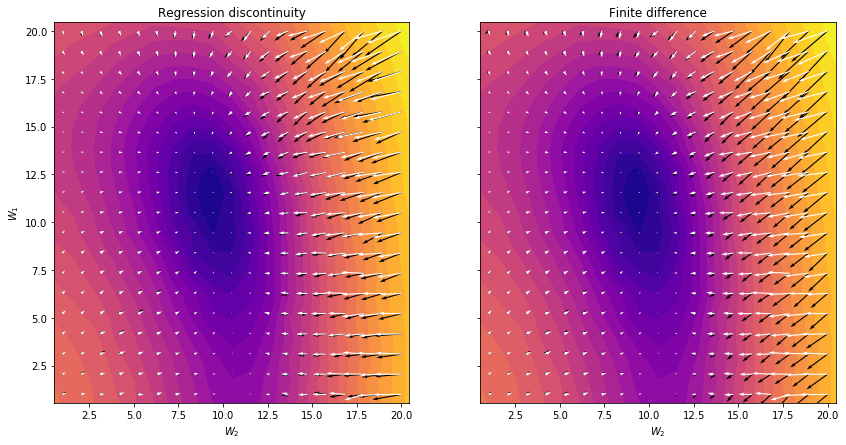

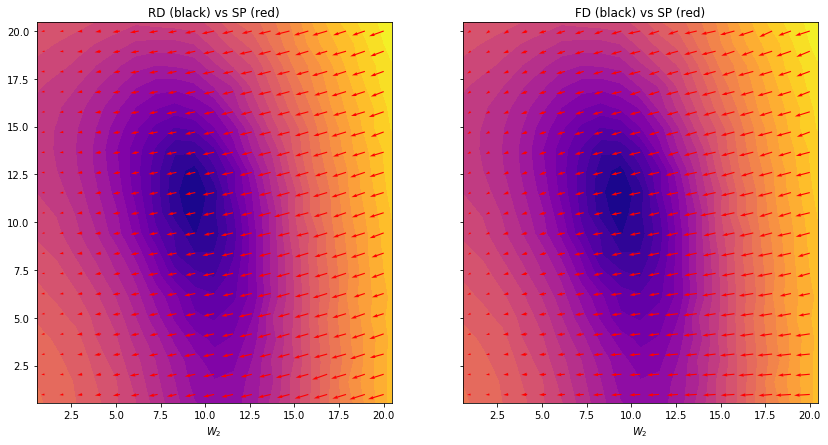

In [315]:
grad = np.gradient(cost2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7), sharey = True)

hada = np.multiply

a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
ax1.quiver(X, Y, -hada(mu2_w2, m_beta_rd_w2[:,:,1]), -hada(mu1_w1, m_beta_rd_w2[:,:,0]), color=(0, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax1.set_title("Regression discontinuity")
ax1.set_xlabel('$W_2$')
ax1.set_ylabel('$W_1$')

#fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
a=ax2.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
ax2.quiver(X, Y, -hada(mu2_w2, m_beta_fd_w2[:,:,1]), -hada(mu1_w1, m_beta_fd_w2[:,:,0]), color=(0, 0, 0))
ax2.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax2.set_title("Finite difference")
ax2.set_xlabel('$W_2$')
#ax2.set_ylabel('$W_1$')
#plt.savefig('./fig_2c.pdf')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7), sharey = True)
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
#Q = ax1.quiver(X, Y, -m_beta_rd_w2[:,:,1], -m_beta_rd_w2[:,:,0], color=(0, 0, 0))
ax1.quiver(X, Y, -hada(mu2_w2, m_beta_sp_w2[:,:,1]), -hada(mu2_w2, m_beta_sp_w2[:,:,0]), color=(1, 0, 0))
#ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax1.set_title("RD (black) vs SP (red)")
ax1.set_xlabel('$W_2$')

a=ax2.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
#Q = ax2.quiver(X, Y, -m_beta_fd_w2[:,:,1], -m_beta_fd_w2[:,:,0], color=(0, 0, 0))
ax2.quiver(X, Y, -hada(mu2_w2, m_beta_sp_w2[:,:,1]), -hada(mu1_w1, m_beta_sp_w2[:,:,0]), color=(1, 0, 0))
#ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
#fig.colorbar(a);
ax2.set_title("FD (black) vs SP (red)")
ax2.set_xlabel('$W_2$')

In [328]:
d_fdbp = np.sqrt((hada(mu1_w1, m_beta_fd_w2[:,:,0])-ds*grad[0])**2 + (hada(mu2_w2, m_beta_fd_w2[:,:,1])-ds*grad[1])**2).reshape((-1,1))
d_rdbp = np.sqrt((hada(mu1_w1, m_beta_rd_w2[:,:,0])-ds*grad[0])**2 + (hada(mu2_w2, m_beta_rd_w2[:,:,1])-ds*grad[1])**2).reshape((-1,1))

err_grad = ds*np.sqrt(grad[0]**2 + grad[1]**2).reshape((-1,1))

d_rdbp = np.divide(d_rdbp, err_grad)
d_fdbp = np.divide(d_fdbp, err_grad)

cv1 = np.divide(np.sqrt(sigma_s1s1), mu_s1).reshape((-1,1))
cv2 = np.divide(np.sqrt(sigma_s2s2), mu_s2).reshape((-1,1))

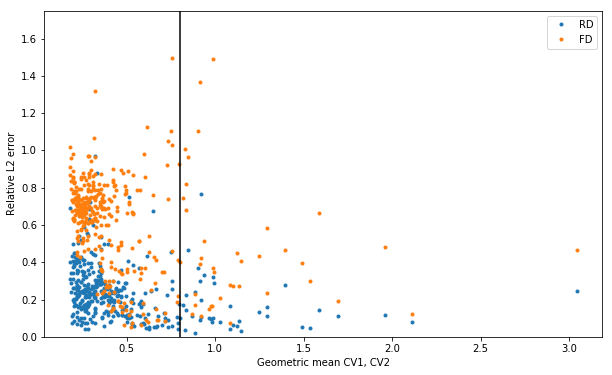

In [357]:
plt.plot(np.sqrt(np.multiply(cv1, cv2)), d_rdbp, '.C0')
plt.plot(np.sqrt(np.multiply(cv1, cv2)), d_fdbp, '.C1')
plt.xlabel('Geometric mean CV1, CV2')
plt.ylabel('Relative L2 error')
plt.ylim([0, 1.75])
plt.legend({'RD', 'FD'})
plt.axvline(x=0.8, color=(0,0,0))

This shows works over a range of CV values. From mean-driven to fluctuation driven

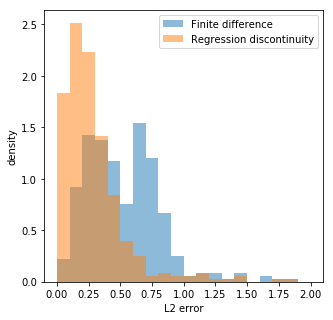

In [263]:
plt.rc('text', usetex=False)
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5));
ax1.hist(d_fdbp, 20, normed=1, range=(0, 2), alpha=0.5);
ax1.hist(d_rdbp, 20, normed=1, range=(0, 2), alpha=0.5);
ax1.set_xlabel('L2 error')
ax1.set_ylabel('density')
ax1.legend(['Finite difference', 'Regression discontinuity']);
#plt.savefig('./fig_2b.pdf')

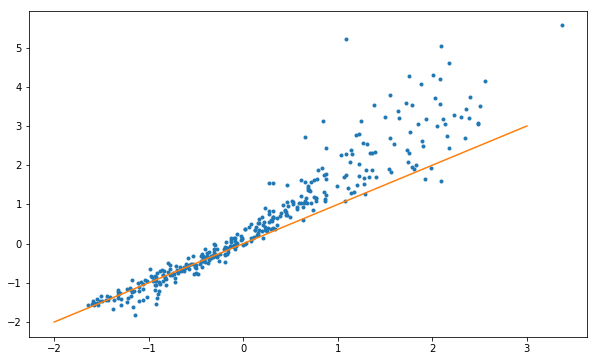

In [259]:
#Plot error vs CV
plt.plot(grad[0].reshape((-1,1)), hada(mu1_w1, m_beta_rd_w2[:,:,0]).reshape((-1,1))/ds, '.')
plt.plot([-2, 3], [-2, 3])

In [257]:
ds

0.0025150289023026188